# TP08 - Sistemas de comunicação (Digital).
Lucas Pereira Fernandes - 07/2021

In [1]:
# here goes your include modules...
import numpy as np
import matplotlib.pyplot as plt

# in this TP we will use scipy modul to read the files
from scipy.io import wavfile
# if you rather to use librosa, use the lines below
import librosa

# below are the module used to play the audio vectors in jupyterlab
from IPython.display import Audio

**TP08 - Sistemas de comunicação (Digital).**

---

Sistemas de comunicação modernos utilizam modulações digitais para diminuir as alterações do sinal enviado ao longo do canal. Na modulação analógica as alterações no canal implicam em grande variação do sinal de mensagem e consequente dificuldade na recepção do sinal.

Nesse TP utilizaremos a modulação BPSK. Bem como nos outros trabalhos, vamos primeiramente tentar compreender as ferramentas para posteriormente resolver uma série de problemas propostos. 

Muita atenção nesse TP, você deverá utilizar muita informação adquirida ao longo do curso e que está dormente em seu cérebro...

---
A célula abaixo gera uma sequência de bits aleatória de tamanho ```sigSize```. A variável data é um vetor (array numpy) que guarda os bits para posterior processamento.

In [2]:
sigSize = 10
data = np.array([np.random.randint(0,2) for i in range(sigSize)])

print(data)

[1 1 1 0 0 1 1 0 1 1]


Abaixo são descritas duas funções importantes para nossos exemplos e no processo de modulação digital.

A função ```bpsk_signaling()``` *transforma* o sinal de bits na forma (0,1) em um sinal na forma (-Eb, +Eb). Esse é um sinal importante para nossos exemplos pois definimos que a modulação *BPSK* têm simbolos defasados em $180^o$.

A função ```bpsk``` assume um $cos(\cdot)$ de frequência ```freq``` como onda portadora.

In [3]:
# Tb = bit duration
# sr = sample rate
# Eb = symbol energy
# freq = carrier frequency

def bpsk_signaling(data, Eb=1, Tb=2, sr=10):
  N = len(data)
  sig_timelength = int(N*Tb)
  t = np.linspace(0, sig_timelength, N*sr)
  
  signaling = np.zeros((N, sr))
  for i in range(N):
    signaling[i,:] = data[i]
  signaling = signaling.reshape(t.shape)
  signaling = 2 * Eb * signaling - Eb
  return t, signaling

def bpsk(data, Eb=1, Tb=2, freq=2, sr=10):
  t, s = bpsk_signaling(data, Eb=Eb, Tb=Tb, sr=sr)    
  return t, np.sqrt(2*Eb/Tb) * np.cos(2*np.pi*freq* t) * s

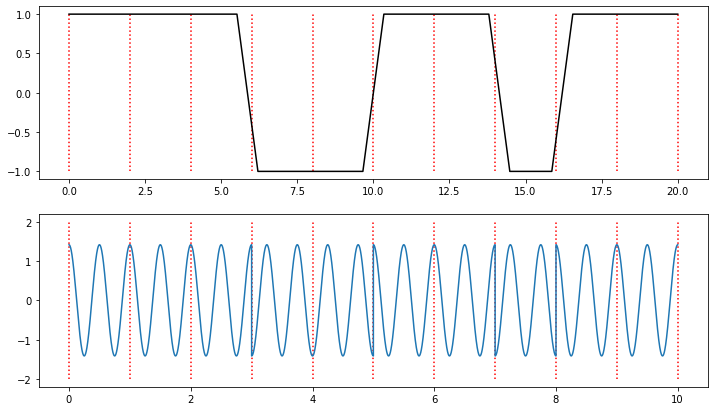

In [4]:
fig = plt.figure(figsize=(12,7))

# -----------
# First plot
# -----------
sr = 3
Tb = 2

# Signaling signal creation
t, s = bpsk_signaling(data, sr = sr, Tb=Tb)

# plot
plt.subplot(211)
for i in range(0, sigSize+1):
  plt.vlines(i*Tb, -1, 1, colors='red', linestyles='dotted')
plt.plot(t, s, 'k')

# -----------
# Second plot
# -----------
sr = 44100
Tb = 1
Eb = 1
fc = 2

# BPSK signal creation
t, s = bpsk(data, Eb = Eb, freq = fc, Tb = Tb, sr = sr)

# plot
plt.subplot(212)
for i in range(0, sigSize+1):
  plt.vlines(i*Tb, -2*Eb, 2*Eb, colors='red', linestyles='dotted')
plt.plot(t, s)

Em um sistema de comunicação digital ou analógico os sinais que chegam ao receptor são analógicos. O que significa que caso a computação/processamento do sinal seja feito de forma digital é preciso que o sinal recebido seja amostrado. Suponha a seguinte cadeia de recepção (simplificada):

<img src="https://raw.githubusercontent.com/rsmarinho/pdscodes/master/f_tp08png.png" alt="VCVS" width="80%"/>

O sinal $\hat{m}(t)$ é o sinal de mensagem corompido pelo canal. Esse é um sinal analógico, em frequência de rádio (dependendo do canal). Esse sinal passa por um *front-end* que tenta "*melhorar*" o sinal. Na saída do bloco de *RF* o sinal é transformado em *banda base* e somente então é amostrado. esse sinal amostrado pode então ser demodulado.

Nos exercícios abaixo vamos supor que o sinal que estamos trabalhando é o sinal **no receptor** corrompido pelo canal e amostrado após o *front-end* de recepção. Ou seja:

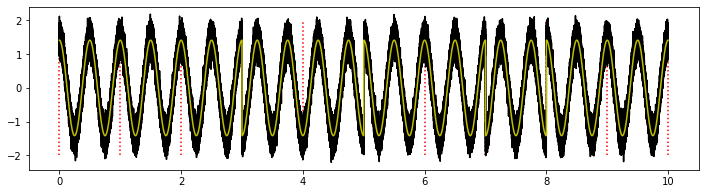

In [5]:
fig = plt.figure(figsize=(12,3))

n = np.random.randn(s.size)
std_dev = 0.2

for i in range(0, sigSize+1):
  plt.vlines(i*Tb, -2*Eb, 2*Eb, colors='red', linestyles='dotted')
plt.plot(t, s + n * std_dev, 'k')
plt.plot(t, s, 'y')


---

**1.** Um canal AWGN é um canal aditivo que adiciona (Aditive) ao sinal enviado ruído branco gaussiano (White Gaussian Noise). Em simulação um canal desse tipo é usualmente simulado com uma função geradora de números aleatórios com distribuição normal (```randn()```). A variancia de uma variável aleatória simulada pode ser variada multiplicando a função ```randn()``` por um valor que indica o desvio padrão da função de distribuição. Então, por exemplo:

(-6.0, 6.0)

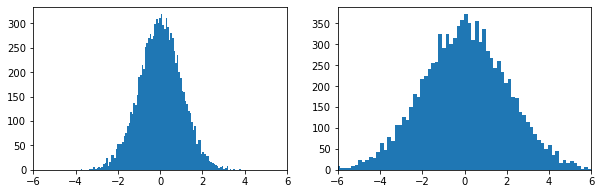

In [6]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
plt.hist(np.random.randn(10000),bins=100)
plt.xlim([-6,6])

plt.subplot(122)
plt.hist(np.random.randn(10000)*2,bins=100)
plt.xlim([-6,6])

Ou seja, no caso de definir o sinal/canal em função da relação sinal ruído (SNR) devemos proseguir da seguinte forma:
```
   variance = 10^(-snr/10);
   noise = sqrt(variance)*randn();
```
Por exemplo:

(-6.0, 6.0)

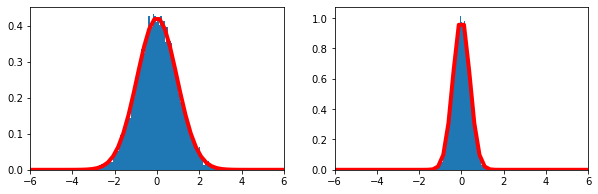

In [7]:
fig = plt.figure(figsize=(10,3))

def normal_pdf(x, mu=0, sigma=1):
    sqrt_two_pi = np.sqrt(np.pi * 2)
    return (1 / (sqrt_two_pi * sigma)) * np.exp(-0.5 * np.power((x - mu)/sigma, 2) )

snr = np.array([0.5, 8])

variance = np.power(10,(-snr/10))
noise = np.random.randn(10000);

plt.subplot(121)
# plot do histograma
plt.hist(noise*np.sqrt(variance[0]),bins=100,density=True)
# plot da FDP gaussiana
plt.plot(np.linspace(-6,6), normal_pdf(np.linspace(-6,6), sigma=np.sqrt(variance[0])), 'r', lw=4)
plt.xlim([-6,6])

plt.subplot(122)
# plot do histograma
plt.hist(noise*np.sqrt(variance[1]),bins=100,density=True)
# plot da FDP gaussiana
plt.plot(np.linspace(-6,6), normal_pdf(np.linspace(-6,6), sigma=np.sqrt(variance[1])), 'r', lw=4)
plt.xlim([-6,6])

Com base nessas informações, faça um modelo de canal em que o sinal enviado seja corrompido por ruído aditivo gaussiano de diferentes valores de energia. 

Em outras palavras: varie a SNR (0.1, 0.2, 1, 5, 10, por exemplo) e mostre os sinais de mensagem BPSK corrompidos.

In [8]:
snr = np.array([0.1, 0.5, 1, 5, 10, 100])

signal = np.zeros([snr.size,s.size])

variancia = 10**(-snr/10)
noise = np.random.randn(s.size);

for count in range(snr.size):
    signal[count,:] = s + noise*np.sqrt(variancia[count])

Text(0.5, 1.0, 'SNR 100')

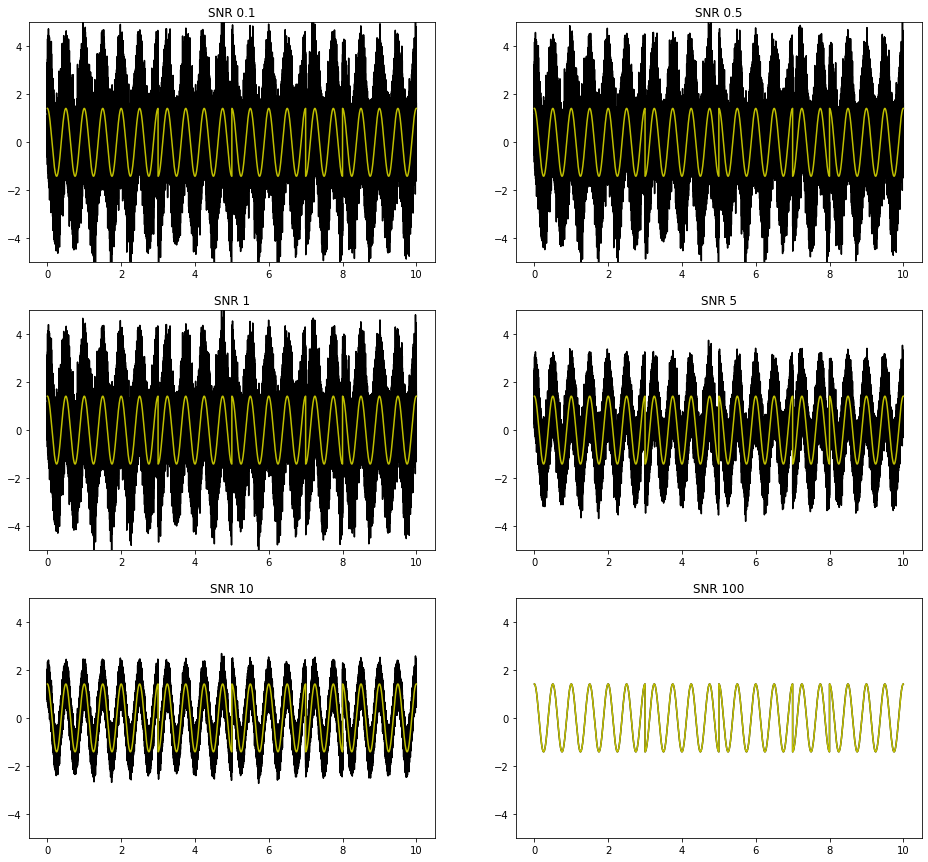

In [9]:
plt.figure(figsize=(16,15))
plt.grid()
    
plt.subplot(321)
plt.plot(t, signal[0,:], 'k')
plt.plot(t, s, 'y')
plt.ylim([-5,5])
plt.title('SNR 0.1')

plt.subplot(322)
plt.plot(t, signal[1,:], 'k')
plt.plot(t, s, 'y')
plt.ylim([-5,5])
plt.title('SNR 0.5')

plt.subplot(323)
plt.plot(t, signal[2,:], 'k')
plt.plot(t, s, 'y')
plt.ylim([-5,5])
plt.title('SNR 1')

plt.subplot(324)
plt.plot(t, signal[3,:], 'k')
plt.plot(t, s, 'y')
plt.ylim([-5,5])
plt.title('SNR 5')

plt.subplot(325)
plt.plot(t, signal[4,:], 'k')
plt.plot(t, s, 'y')
plt.ylim([-5,5])
plt.title('SNR 10')

plt.subplot(326)
plt.plot(t, signal[5,:], 'k')
plt.plot(t, s, 'y')
plt.ylim([-5,5])
plt.title('SNR 100')

**2.** O código ``` t, s = bpsk(data, Eb = 1, freq = 1000, Tb = 1, sr = 44100)``` gera um sinal bpsk modulado em uma frequência de amostragem de 44100 Hz a partir de uma sequência binária ```data```. A frequência da onda portadora do sinal é de 1 kHz. Utilizando seus conhecimento de PDS, Comunicação Digital e Processos Estocásticos, faça uma função que retorne a sequência original ```data``` a partir do sinal bpsk.

DICA: Suponha que o sinal é síncrono, ou seja, que você sabe quando é o início e o fim de cada símbolo, e calcule a ortogonalidade (produto interno) entre funções conhecidas de **mesmo tamanho** do sinal recebido.

In [10]:
sr = 44100
t, s = bpsk(data, Eb = 1, freq = 1000, Tb = 1, sr = sr)

Vamos analisar os inícios de cada símbolo:

In [11]:
inicios = np.zeros((5*data.size))
for count in range(data.size):
    inicios[5*count:5*(count+1)]= s[sr*count:sr*count +5]

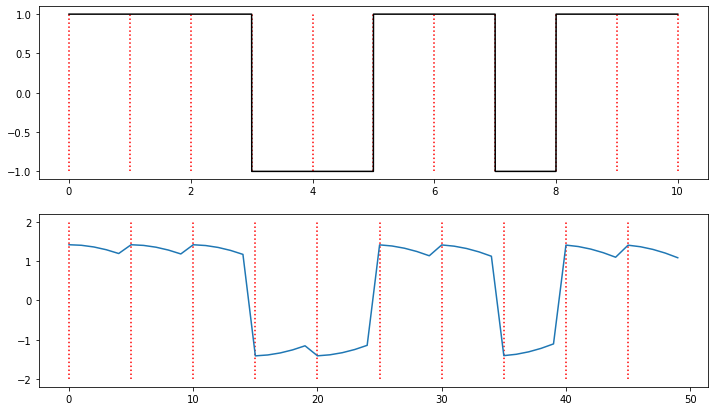

In [12]:
fig = plt.figure(figsize=(12,7))

t, s = bpsk_signaling(data, sr = sr, Tb=Tb)
# plot
plt.subplot(211)
for i in range(0, sigSize+1):
  plt.vlines(i*Tb, -1, 1, colors='red', linestyles='dotted')
plt.plot(t, s, 'k')

sr = 44100
t, s = bpsk(data, Eb = 1, freq = 1000, Tb = 1, sr = sr)

# plot
plt.subplot(212)
for i in range(data.size):
  plt.vlines(i*5, -2*Eb, 2*Eb, colors='red', linestyles='dotted')
plt.plot(inicios)

Observa-se que no caso dos símbolos em nível 0, temos que o sinal s é crescente. No caso do sinal em nível 1, temos que o sinal s é decrescente, portanto:

In [13]:
bits_reconstruido = np.zeros_like(data)
for count in range(data.size):
    if s[count*sr:(count+1)*sr][3] > s[count*sr:(count+1)*sr][7]:
        bits_reconstruido[count] = 1

In [14]:
bits_reconstruido

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1])

In [15]:
data

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1])